# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN(os.path.join("..", "data"), split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN(os.path.join("..", "data"), split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    
    # raise Exception("Not implemented")
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        prediction = model(x)    

        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.818326, Train accuracy: 0.416050, Val accuracy: 0.539076
Average loss: 1.452877, Train accuracy: 0.584104, Val accuracy: 0.594976
Average loss: 1.377077, Train accuracy: 0.619902, Val accuracy: 0.624189


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.167803, Train accuracy: 0.220302, Val accuracy: 0.278070
Average loss: 1.923935, Train accuracy: 0.317322, Val accuracy: 0.380930
Average loss: 1.750283, Train accuracy: 0.399379, Val accuracy: 0.416149
Average loss: 1.695980, Train accuracy: 0.425212, Val accuracy: 0.430551
Average loss: 1.677449, Train accuracy: 0.437549, Val accuracy: 0.439765


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.195056, Train accuracy: 0.235505, Val accuracy: 0.336837
Average loss: 2.013910, Train accuracy: 0.362932, Val accuracy: 0.401884
Average loss: 1.910031, Train accuracy: 0.424172, Val accuracy: 0.469320
Average loss: 1.833518, Train accuracy: 0.470498, Val accuracy: 0.493755
Average loss: 1.771267, Train accuracy: 0.500819, Val accuracy: 0.533342


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
# Learing rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler
    for epoch in range(num_epochs):
        scheduler.step()  # use the sheduler
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.931656, Train accuracy: 0.359281, Val accuracy: 0.459081
Average loss: 1.785536, Train accuracy: 0.442787, Val accuracy: 0.427275
Average loss: 1.745342, Train accuracy: 0.462239, Val accuracy: 0.488431
Average loss: 1.737706, Train accuracy: 0.459987, Val accuracy: 0.424544
Average loss: 1.699353, Train accuracy: 0.474542, Val accuracy: 0.494301


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [36]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    
    sampler = SubsetSampler(indices)
    batch_size = 64
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=sampler)
    
    predictions, ground_truth = [], []
    for (x, y) in loader:
        prediction = model(x)    

        indices = torch.argmax(prediction, 1)
        
        predictions.extend(list(indices.numpy()))
        ground_truth.extend(list(y.numpy()))
        
    predictions = np.array(predictions)
    ground_truth = np.array(ground_truth)
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

In [37]:
# my added checking
assert np.sum(np.array(predictions) == np.array(gt)) / len(predictions) == val_history[-1]

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.
![confusion_matrix](images\confusion_matrix0.png)
или в варианте бинарной классификации "один против всех":
![confusion_matrix](images\confusion_matrix.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

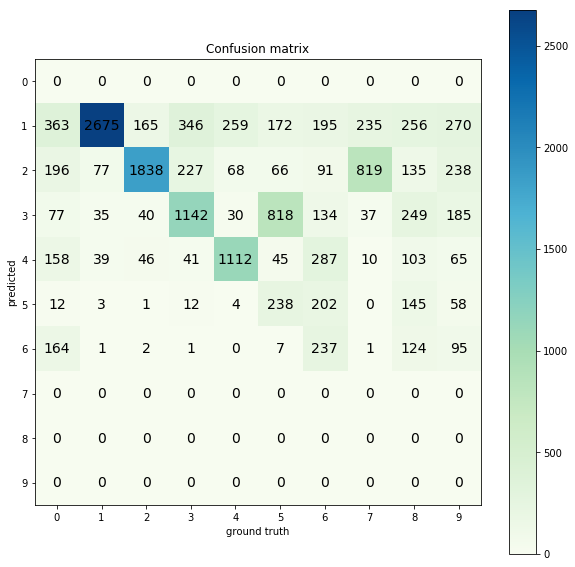

In [46]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    num_class = 10
    confusion_matrix = np.zeros((num_class, num_class), np.int)
    
    for i in range(num_class):
        for j in range(num_class):
            confusion_matrix[i, j] = np.sum(predictions[ground_truth == j] == i)
#             confusion_matrix[i, j] = np.sum((ground_truth == j) & (predictions == i))  # alternative variant
    
    # TODO: Implement filling the prediction matrix
#     return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

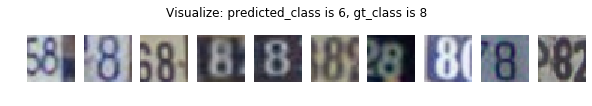

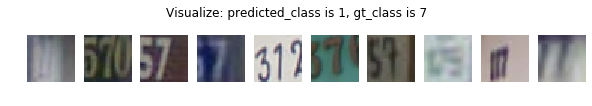

In [41]:
data_train_images = dset.SVHN(os.path.join("..", "data"), split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")
    title = f"Visualize: predicted_class is {predicted_class}, gt_class is {gt_class}"
    indices = val_indices[(ground_truth == gt_class) & (predictions == predicted_class)]
    
    visualize_images(indices, data, title, max_num=10)

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

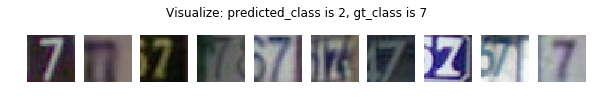

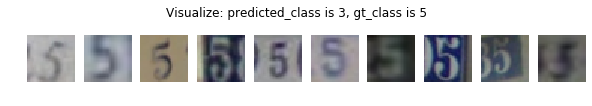

In [42]:
visualize_predicted_actual(2, 7, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(3, 5, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

### Начало пути

In [43]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.4959


### My experiments

In [67]:
# Experiment here!

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        if scheduler:
            scheduler.step()  # use the sheduler
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def loss_accuracy_plot(loss_history, train_history, val_history):
    plt.figure(figsize=(10, 7))
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(loss_history)
    plt.subplot(212)
    plt.title("Train/validation accuracy")
    plt.plot(train_history, label="train")
    plt.plot(val_history, label="validation")
    plt.legend();

## 1

In [57]:
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler)

Average loss: 2.006653, Train accuracy: 0.324933, Val accuracy: 0.413009
Average loss: 1.782582, Train accuracy: 0.429342, Val accuracy: 0.465702
Average loss: 1.703969, Train accuracy: 0.471948, Val accuracy: 0.495529
Average loss: 1.675120, Train accuracy: 0.490223, Val accuracy: 0.509863
Average loss: 1.644636, Train accuracy: 0.510716, Val accuracy: 0.527336
Average loss: 1.634406, Train accuracy: 0.515988, Val accuracy: 0.521193
Average loss: 1.616358, Train accuracy: 0.527506, Val accuracy: 0.535800
Average loss: 1.610558, Train accuracy: 0.531891, Val accuracy: 0.540100
Average loss: 1.599858, Train accuracy: 0.536123, Val accuracy: 0.553409
Average loss: 1.597180, Train accuracy: 0.538887, Val accuracy: 0.545082
Average loss: 1.590388, Train accuracy: 0.542334, Val accuracy: 0.549997
Average loss: 1.589194, Train accuracy: 0.542914, Val accuracy: 0.553955
Average loss: 1.584592, Train accuracy: 0.544893, Val accuracy: 0.549041
Average loss: 1.583409, Train accuracy: 0.545780, V

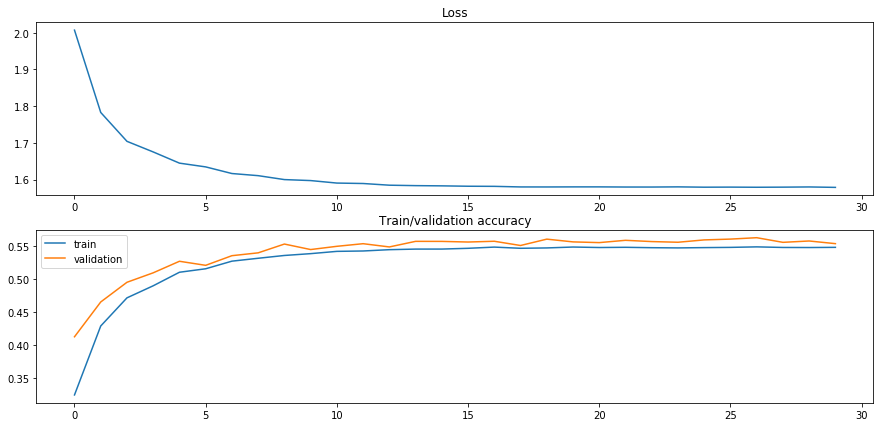

In [62]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [59]:
# Как всегда, в конце проверяем на test set
def print_test_accuracy(nn_model, data_test, batch_size):
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
    test_accuracy = compute_accuracy(nn_model, test_loader)
    print("Test accuracy: %2.4f" % test_accuracy)

print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.5535


## 2

In [63]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 7
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1, momentum=0.8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler)

Average loss: 1.992198, Train accuracy: 0.356158, Val accuracy: 0.446522
Average loss: 1.760821, Train accuracy: 0.473638, Val accuracy: 0.494779
Average loss: 1.679558, Train accuracy: 0.504368, Val accuracy: 0.528633
Average loss: 1.654540, Train accuracy: 0.521892, Val accuracy: 0.543444
Average loss: 1.621827, Train accuracy: 0.544142, Val accuracy: 0.547403
Average loss: 1.611692, Train accuracy: 0.550575, Val accuracy: 0.553819
Average loss: 1.591810, Train accuracy: 0.562195, Val accuracy: 0.569244


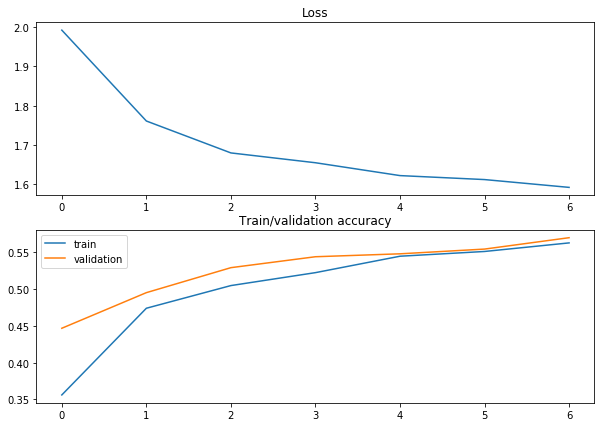

In [68]:
loss_accuracy_plot(loss_history, train_history, val_history)

## 3

In [75]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 5
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)  # change optimazer to Adam 
                                                        # and lr changed to 1e-5 (with 1e-3 was very strong overfitting)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler=None)  # without sheduler

Average loss: 2.193195, Train accuracy: 0.247620, Val accuracy: 0.430960
Average loss: 1.983209, Train accuracy: 0.477016, Val accuracy: 0.522626
Average loss: 1.866985, Train accuracy: 0.520390, Val accuracy: 0.544263
Average loss: 1.781464, Train accuracy: 0.544415, Val accuracy: 0.572521
Average loss: 1.710850, Train accuracy: 0.562519, Val accuracy: 0.588902
Wall time: 1min 57s


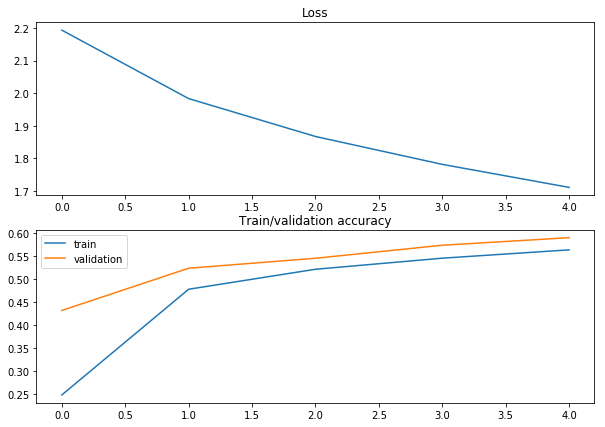

In [76]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [79]:
print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.5572


## 4

In [80]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 15  # was increased the epochs number
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler)

Average loss: 2.195668, Train accuracy: 0.242296, Val accuracy: 0.382022
Average loss: 2.012218, Train accuracy: 0.438419, Val accuracy: 0.497304
Average loss: 1.922195, Train accuracy: 0.498464, Val accuracy: 0.515869
Average loss: 1.876025, Train accuracy: 0.518804, Val accuracy: 0.546379
Average loss: 1.841830, Train accuracy: 0.532659, Val accuracy: 0.546720
Average loss: 1.821810, Train accuracy: 0.539842, Val accuracy: 0.555935
Average loss: 1.804168, Train accuracy: 0.548135, Val accuracy: 0.568698
Average loss: 1.794443, Train accuracy: 0.552179, Val accuracy: 0.563852
Average loss: 1.786648, Train accuracy: 0.554704, Val accuracy: 0.573476
Average loss: 1.781384, Train accuracy: 0.556922, Val accuracy: 0.570951
Average loss: 1.778296, Train accuracy: 0.557281, Val accuracy: 0.571087
Average loss: 1.774470, Train accuracy: 0.560659, Val accuracy: 0.572248
Average loss: 1.773731, Train accuracy: 0.558612, Val accuracy: 0.572179
Average loss: 1.772552, Train accuracy: 0.560250, V

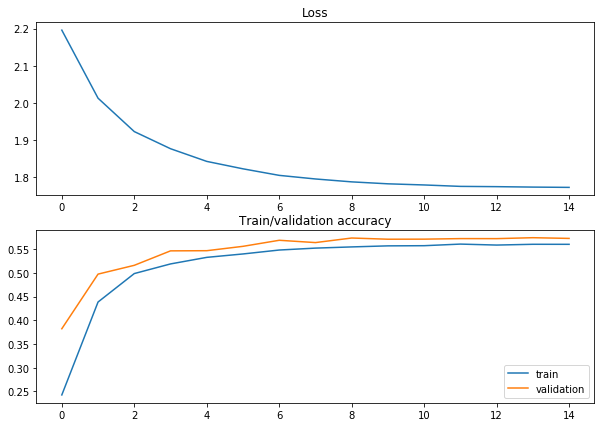

In [81]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [82]:
print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.5491


## 5

In [83]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 15
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler=None)  # without sheduler

Average loss: 2.178578, Train accuracy: 0.259359, Val accuracy: 0.417036
Average loss: 1.959410, Train accuracy: 0.473859, Val accuracy: 0.532046
Average loss: 1.830384, Train accuracy: 0.539279, Val accuracy: 0.574159
Average loss: 1.733793, Train accuracy: 0.568491, Val accuracy: 0.594840
Average loss: 1.652814, Train accuracy: 0.595792, Val accuracy: 0.623439
Average loss: 1.585141, Train accuracy: 0.613060, Val accuracy: 0.634837
Average loss: 1.526983, Train accuracy: 0.625653, Val accuracy: 0.647123
Average loss: 1.478661, Train accuracy: 0.635259, Val accuracy: 0.653061
Average loss: 1.436060, Train accuracy: 0.642716, Val accuracy: 0.669511
Average loss: 1.399209, Train accuracy: 0.652885, Val accuracy: 0.665961
Average loss: 1.367559, Train accuracy: 0.661246, Val accuracy: 0.676746
Average loss: 1.338180, Train accuracy: 0.672184, Val accuracy: 0.675995
Average loss: 1.313290, Train accuracy: 0.678685, Val accuracy: 0.691147
Average loss: 1.289089, Train accuracy: 0.684947, V

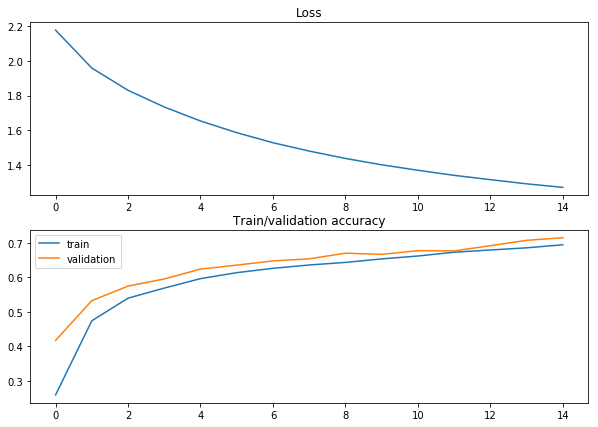

In [84]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [85]:
print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.6846


## 6

In [86]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30  # was increased the epochs number yet
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)  # add sheduler

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler=None)

Average loss: 2.178831, Train accuracy: 0.273982, Val accuracy: 0.400246
Average loss: 1.981649, Train accuracy: 0.441337, Val accuracy: 0.484609
Average loss: 1.864929, Train accuracy: 0.498789, Val accuracy: 0.530407
Average loss: 1.776626, Train accuracy: 0.534843, Val accuracy: 0.559279
Average loss: 1.702905, Train accuracy: 0.562195, Val accuracy: 0.588151
Average loss: 1.637120, Train accuracy: 0.584940, Val accuracy: 0.610812
Average loss: 1.582570, Train accuracy: 0.602157, Val accuracy: 0.633404
Average loss: 1.532655, Train accuracy: 0.618725, Val accuracy: 0.644256
Average loss: 1.489347, Train accuracy: 0.632034, Val accuracy: 0.655860
Average loss: 1.450574, Train accuracy: 0.642562, Val accuracy: 0.663641
Average loss: 1.415861, Train accuracy: 0.653875, Val accuracy: 0.675585
Average loss: 1.385762, Train accuracy: 0.663823, Val accuracy: 0.682411
Average loss: 1.361980, Train accuracy: 0.668771, Val accuracy: 0.689714
Average loss: 1.337708, Train accuracy: 0.677524, V

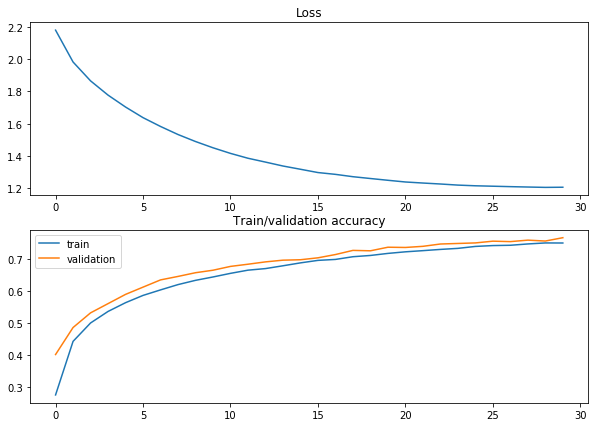

In [87]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [88]:
print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.7428


## 7

In [89]:
%%time
# here we will iterate over the parameters
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 200),  # was added layer
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True),
            nn.Linear(200, 100), 
            nn.BatchNorm1d(100), 
            nn.ReLU(inplace=True), 
            nn.Linear(100, 10),
         )

num_epochs = 30
optimizer = optim.Adam(nn_model.parameters(), lr=1e-5, weight_decay=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, 
                                                       optimizer, num_epochs, scheduler=None)  # without sheduler

Average loss: 2.230481, Train accuracy: 0.187080, Val accuracy: 0.347894
Average loss: 1.978577, Train accuracy: 0.439511, Val accuracy: 0.529657
Average loss: 1.789346, Train accuracy: 0.549039, Val accuracy: 0.591154
Average loss: 1.660015, Train accuracy: 0.594035, Val accuracy: 0.622142
Average loss: 1.567009, Train accuracy: 0.616541, Val accuracy: 0.645075
Average loss: 1.492630, Train accuracy: 0.633519, Val accuracy: 0.656883
Average loss: 1.431202, Train accuracy: 0.648551, Val accuracy: 0.674766
Average loss: 1.379766, Train accuracy: 0.662833, Val accuracy: 0.687257
Average loss: 1.334043, Train accuracy: 0.673566, Val accuracy: 0.702341
Average loss: 1.295551, Train accuracy: 0.685442, Val accuracy: 0.709303
Average loss: 1.263709, Train accuracy: 0.694110, Val accuracy: 0.707733
Average loss: 1.231570, Train accuracy: 0.705235, Val accuracy: 0.730189
Average loss: 1.202276, Train accuracy: 0.715746, Val accuracy: 0.732168
Average loss: 1.180904, Train accuracy: 0.723288, V

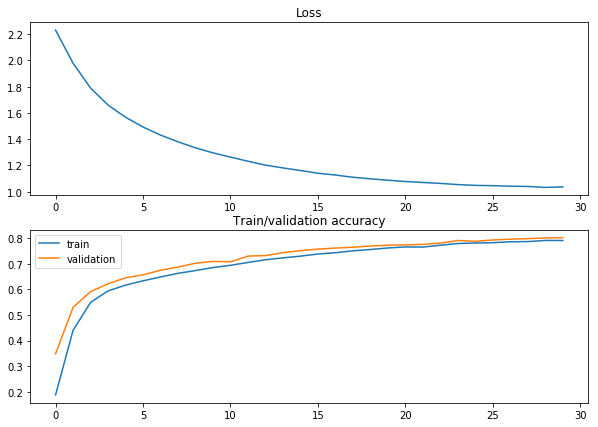

In [90]:
loss_accuracy_plot(loss_history, train_history, val_history)

In [91]:
print_test_accuracy(nn_model, data_test, batch_size)

Test accuracy: 0.7773
